## Regression and LDA (Linear Discriminant Analysis)

In this script, we're going to expand on what you've learned last week. First, we'll view how to do linear regression with statsmodels, and then learn how to identify outliers, leverage points and influential points. Then, we're  going to use the bird data set to do linear regression in multiple variables (multilinear regression). We will make use of the machine-learning library [scikit-learn](https://scikit-learn.org) and the statistical visualization library [seaborn](https://seaborn.pydata.org). Finally, we'll learn how to use LDA for more complication classification problems.

---
*keywords*: regression: outliers, leverage points, multilinear regression, logistic regression &mdash; classifiers: Linear Discriminant Analysis (LDA)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.api as sma
from sklearn import (linear_model, datasets, metrics,
                     discriminant_analysis)

import warnings
warnings.filterwarnings('ignore')

We start by analysing random data the visualized the process:

The rsquared values is 0.5811883958393314


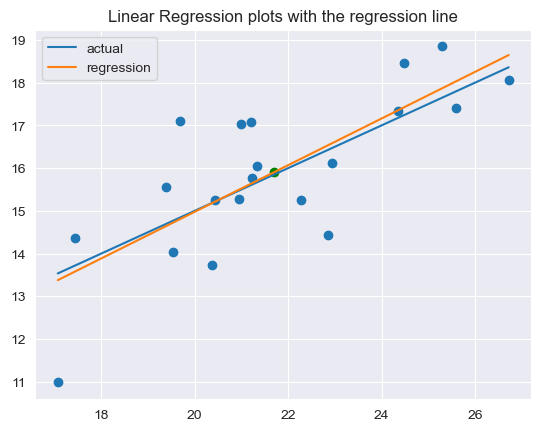

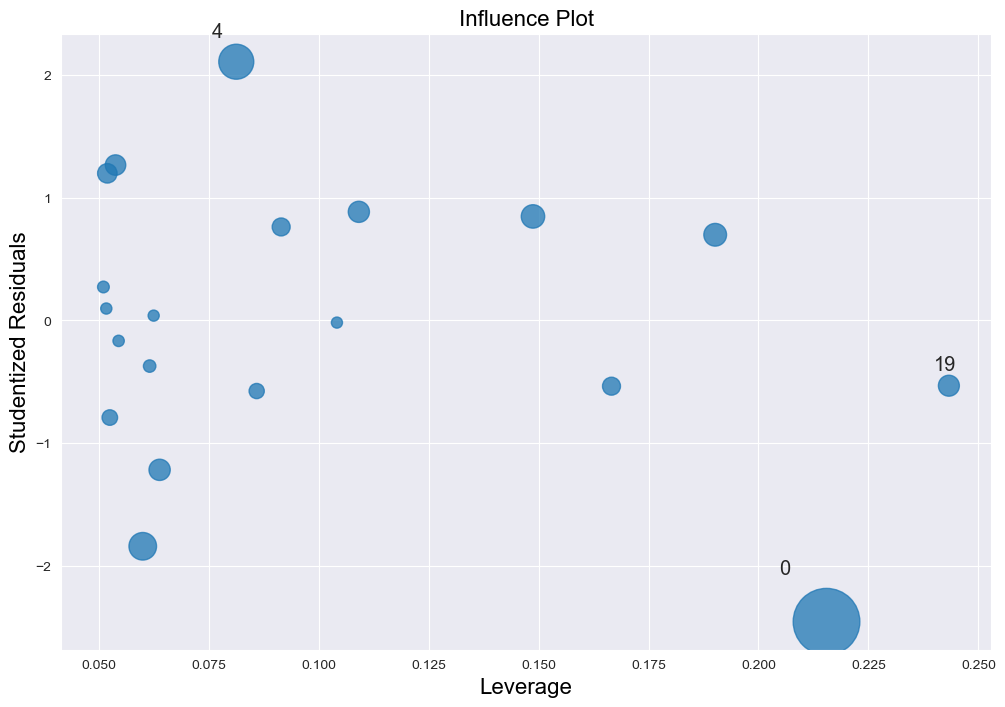

In [4]:
np.random.seed(0)
x1 = np.sort(np.random.normal(20, 3, 20))
y0 = 5 + 0.5 * x1
y1 = 5 + 0.5 * x1 + np.random.normal(0, 1, 20)

# by default `intercept` is not included in fitting the model. We explicitly add it here.
lm = sma.OLS(y1, sma.add_constant(x1)).fit()
print("The rsquared values is " + str(lm.rsquared))

plt.scatter(x1, y1)
plt.scatter(np.mean(x1), np.mean(y1), color = "green")
plt.plot(x1, y0, label = "actual")
plt.plot(x1, lm.predict(), label = "regression")
plt.title("Linear Regression plots with the regression line")
plt.legend()

fig, ax = plt.subplots(figsize=(12,8))
fig = sma.graphics.influence_plot(lm, alpha  = 0.05, ax = ax, criterion="cooks")

# high leverage doesn't mean high influence!!
# 4: outlier
# 19: high leverage
# 0: influenal (outlier and high leverage)
# things with number are outlier or high leverage, big ones are more influental

Observations:-
1. High Rsquared value
2. Y-axis represents the residuals. So, point 0 is likely to be an outlier
3. Points 0 and 19 are high leverage data points

### Generate a Dataframe

In [7]:
# Creating and saving a dataframe
n = 100 
x = np.linspace(0, 10, n)
x[-1] = 20 # one of these values is going to be influental
x[-2] = 18

eps = np.random.normal(0, 0.5, size=x.shape)
y = 0.5*x + 2. + eps
y[-1] = 10
y[10] = 5
y[50] = 1

df = pd.DataFrame({'x': x, 'y': y})
df.to_csv('numbers.csv', index=False)

### Leverage statistics

In [8]:
numbers = pd.read_csv('numbers.csv')
numbers.head()

,x,y
0,0.00000,1.475724
1,0.10101,1.340496
2,0.20202,1.247875
3,0.30303,3.126903
4,0.40404,1.947194


We perform linear regression

The rsquared value is 0.86688


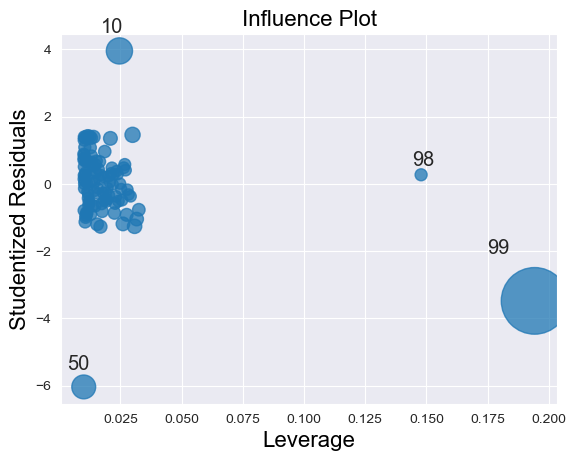

In [9]:
lm = sma.OLS(y, sma.add_constant(x)).fit()
print("The rsquared value is " + str(round(lm.rsquared,5)))
fig = sma.graphics.influence_plot(lm, alpha  = 0.05, criterion="cooks")

We calculate the leverage and plot it against the residuals. Usefule is the `get_influence` function where leverage and studentized_residuals can be obtained from the `influence` object.

Text(0, 0.5, 'studentized residuals')

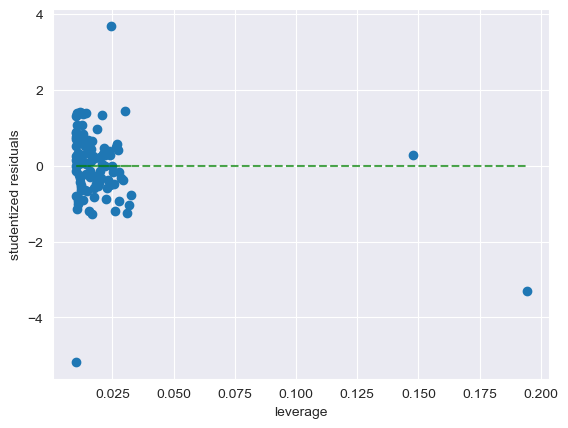

In [10]:
influence = lm.get_influence()
leverage  = influence.hat_matrix_diag
studentized_residuals = influence.resid_studentized 
plt.scatter(leverage, studentized_residuals)
plt.plot(leverage, np.zeros_like(leverage), 'g--', alpha = 0.7)
plt.xlabel('leverage')
plt.ylabel('studentized residuals')


Next, we calculate the leverage statistics with this formula: $$h_i = \frac{1}{n} + \frac{1}{n - 1} \left( \frac{x_i - \bar{x}}{\sigma_{x}} \right)^{2}$$ We compare the results to the ones calculated using the function call.

Text(0, 0.5, 'studentized residuals')

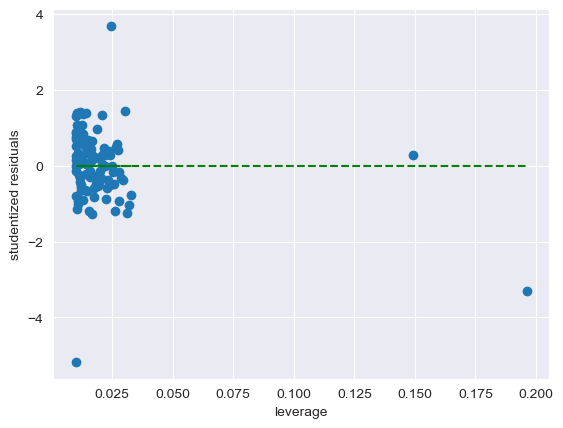

In [11]:
n = len(x)
h = np.zeros(n)
xbar = np.mean(x)
sigma = np.std(x)

for i in range(n):
    h[i] = (1/n) + (1/(n-1))*((x[i]-xbar)/sigma)**2
    
leverage_lecture = h

plt.scatter(leverage_lecture, studentized_residuals)
plt.plot(leverage_lecture, np.zeros_like(leverage_lecture), 'g--')
plt.xlabel('leverage')
plt.ylabel('studentized residuals')


The leverage calculated from the formula from the lecture seems a lot more influental than the one calculated by statsmodels.

### Multilinear Regression

In [12]:
# Load the `bird_data_vincze_etal_2015.csv` into a pandas dataframe
df = pd.read_csv('data/bird_data_vincze_etal_2015.csv')
df.head()

,Species,Migration distance,Body mass,Brain mass,Size of cerebellum,Size of telencephalon,Size of optic lobe,Wing aspect ratio,Wing area
0,Accipiter gentilis,542.0,1100.0,7.674,1.088,4.617,0.837,5.841,0.193
1,Accipiter nisus,2938.1,260.0,3.081,0.499,1.593,0.440,5.891,0.093
2,Acrocephalus scirpaceus,3577.0,14.0,0.483,0.066,0.282,0.070,4.835,0.008
3,Aegithalos caudatus,26.1,7.5,0.456,0.035,0.283,0.059,4.463,0.007
4,Aegypius monachus,972.2,9000.0,24.808,2.812,17.936,1.020,NaN,NaN


First, we explore, drop unnecessary columns and tidy the dataframe.

In [13]:
print('number of columns:', df.shape[1])
df.describe() # add histograms, .info()

number of columns: 9


,Migration distance,Body mass,Brain mass,Size of cerebellum,Size of telencephalon,Size of optic lobe,Wing aspect ratio,Wing area
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,91.000000,91.000000
mean,2208.464474,1746.874342,5.336224,0.637612,3.618500,0.356868,5.981209,0.088297
std,2391.028832,8069.652638,6.632211,0.854241,4.716583,0.324252,1.180264,0.118651
min,0.000000,5.400000,0.357000,0.035000,0.219000,0.041000,4.332000,0.006000
25%,0.000000,55.425000,1.171500,0.148750,0.729000,0.120750,5.042000,0.015000
50%,1373.350000,255.000000,3.260000,0.373000,2.007000,0.257500,5.841000,0.044000
75%,3592.900000,1062.500000,6.291000,0.703250,4.382250,0.449000,6.606500,0.098500
max,8465.800000,90000.000000,41.058000,6.055000,27.072000,1.788000,9.610000,0.662000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Species                152 non-null    object 
 1   Migration distance     152 non-null    float64
 2   Body mass              152 non-null    float64
 3   Brain mass             152 non-null    float64
 4   Size of cerebellum     152 non-null    float64
 5   Size of telencephalon  152 non-null    float64
 6   Size of optic lobe     152 non-null    float64
 7   Wing aspect ratio      91 non-null     float64
 8   Wing area              91 non-null     float64
dtypes: float64(8), object(1)
memory usage: 10.8+ KB


<Axes: ylabel='Density'>

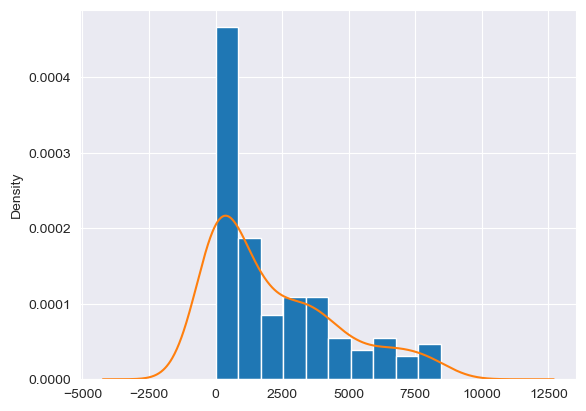

In [16]:
# some distribution
df['Migration distance'].hist(density = True)
df['Migration distance'].plot.kde()

In [22]:
# we drop the column species, as we wont need it
df = df.drop(columns = 'Species')

In [23]:
# check for nans
df.isnull().values.any()

True

In [24]:
 # clean the nans
print(df.shape[0]) # number of rows before dropping
df = df.dropna()
print(df.shape[0]) # number of rows after

152
91


Some birds do not migrate. We can drop such rows as well. However, in this exercise, we keep things simple
and add a value of 1 to each of the migration distances.

In [25]:
df['Migration distance'] = df['Migration distance'] + 1.
df.head()

,Migration distance,Body mass,Brain mass,Size of cerebellum,Size of telencephalon,Size of optic lobe,Wing aspect ratio,Wing area
0,544.0,1100.0,7.674,1.088,4.617,0.837,5.841,0.193
1,2940.1,260.0,3.081,0.499,1.593,0.440,5.891,0.093
2,3579.0,14.0,0.483,0.066,0.282,0.070,4.835,0.008
3,28.1,7.5,0.456,0.035,0.283,0.059,4.463,0.007
6,1109.4,39.0,1.176,0.087,0.865,0.115,5.430,0.024


We use the remaining fields to predict the migration distance. Hence, we update the dataframe as follows

In [26]:
X = df.drop('Migration distance', axis=1)
y = df['Migration distance']

Here, we perform multilinear regression y ~ x. We plot the residuals and compute the rsquared value.

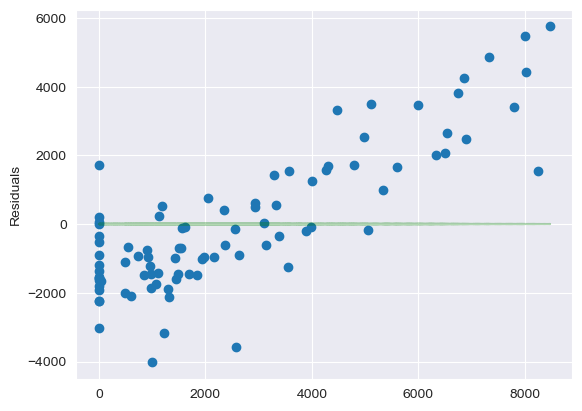

The rsquared value is 0.3048204006495586


In [27]:
lm = linear_model.LinearRegression().fit(X,y)
predict = lm.predict(X)
r2_score = lm.score(X,y)

plt.scatter(y,y-predict)
plt.ylabel('Residuals')
plt.plot(y, np.zeros_like(y), 'g--', alpha = 0.3)
plt.show()

print('The rsquared value is ' + str(r2_score))


The plotted residuals show a pattern and the rquared values is low, which means that the model is weak and doesn't explain much.

### Transforming skewed data
We log-transform the Migration distance to fix the residuals.

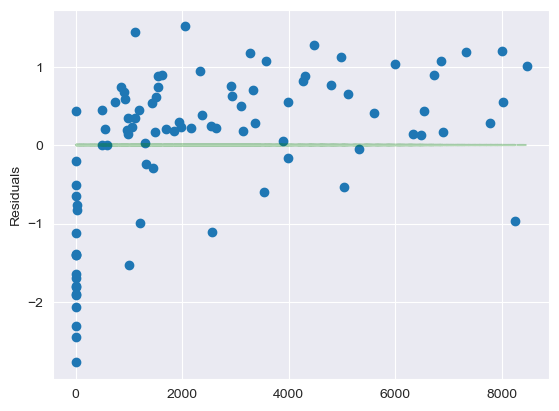

The rsquared value is 0.39921416140298116


In [28]:
X = df.drop('Migration distance', axis=1)
y = df['Migration distance']
ylog = np.log10(df['Migration distance'])

lm = linear_model.LinearRegression().fit(X,ylog)
predict = lm.predict(X)
r2_score = lm.score(X,ylog)

plt.scatter(y,ylog-predict)
plt.ylabel('Residuals')
plt.plot(y, np.zeros_like(y), 'g--', alpha = 0.3)
plt.show()

print('The rsquared value is ' + str(r2_score))


### Classification with logistic regression and linear discriminant analysis

#### Logistic regression
 Logistic regression is the appropriate tool when the dependent variable is dichotomous (binary). We're going to apply this tool the [iris flower dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) and see if we can classify flowers correctly.

The iris dataset is included in scikit-learn.

In [33]:
iris = datasets.load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

This function returns a dictionary that contains a bunch of different fields. All the data points are contained in 'data'. The four columns correspond to the following four features.

In [34]:
iris.data.shape

(150, 4)

In [35]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

For every data point, the respective class label is stored in target. There is a total of three classes.

In [36]:
iris.target.shape

(150,)

In [37]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [38]:
df = pd.DataFrame(iris.data)  # create a dataframe from the iris data
cols = [name for name in iris.feature_names]  # define the column names
df.columns = cols  # set the column names

In [39]:
# Add the species column as the target
df['species'] = iris.target  # add the species column
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


To further explore the iris the we pair plot all the columns to find potential relationships.

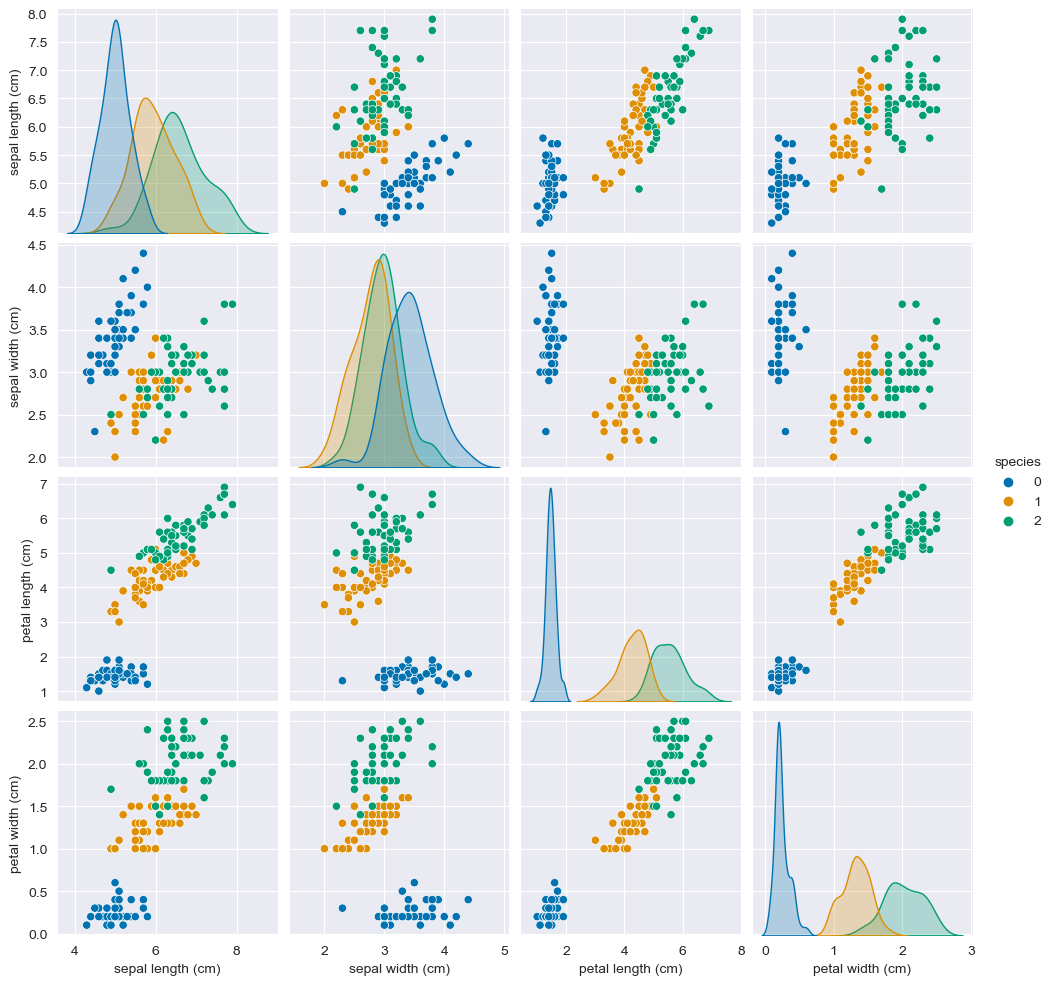

In [40]:
sns.pairplot(df, hue = 'species', palette='colorblind')

We want to focus on binary classification, and hence we discard all data points belonging to a certain class. This can be done by, for example, selecting all the rows that do not belong to that class. Here, we drop the class 'virginica'.

In [42]:
idcs = iris.target != 2  # get all the indices where the class is not 2
data = iris.data[idcs].astype(np.float32)
target = iris.target[idcs].astype(int)

Now, we buil the logistic regression model. We define the explanatory and the response variable below:

In [46]:
X = data[:, 3:]
y = target

We build a logistic regression model y ~ x and find its accuracy.

In [47]:
# here we use petal width
lm = linear_model.LogisticRegression().fit(X,y)

In [48]:
prediction = lm.predict(X)
accuracy =  metrics.accuracy_score(y, prediction)

print(('The prediction accuracy of the model is {}%').format(100*int(accuracy)))

The prediction accuracy of the model is 100%


Next, we use your trained model to predict the probability of the petal width being assigned to the right flower. We do this visually by plotting the probability distributions of seposa and versicolor according to the model.

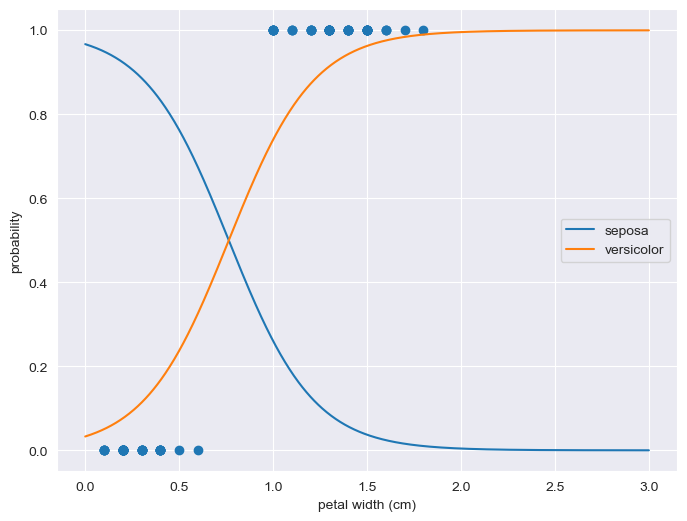

In [54]:
### Once you have correctly solved the exercise, run this cell.
xarr = np.linspace(0, 3, 1000).reshape(-1, 1)
yprob = lm.predict_proba(xarr)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(X, y)
ax.plot(xarr, yprob[:, 0], label='seposa')
ax.plot(xarr, yprob[:, 1], label='versicolor')
ax.set_xlabel(iris.feature_names[3])
ax.set_ylabel('probability')
ax.legend()

## Linear Discriminant Analysis (LDA)
We're going to keep working with the iris dataset from the last exercise. We will use the built-in classifier in scikit-learn.

We start off with a scatter plot where the colors indicate the species.

<Axes: xlabel='sepal length (cm)', ylabel='petal length (cm)'>

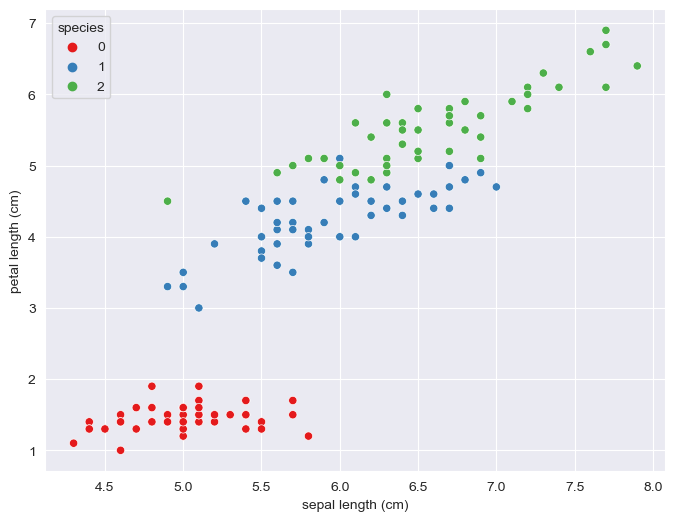

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(x = 'sepal length (cm)', y = 'petal length (cm)',
                hue='species', data=df, palette='Set1')

In [60]:
# Let us define set of variables
X = df[['sepal length (cm)', 'petal length (cm)']]
y = iris.target

Now we are ready to fit the LDA model, which uses Linear Discriminant Analysis.

In [61]:
# fit
lda = discriminant_analysis.LinearDiscriminantAnalysis().fit(X,y)

With the following code we can visualize the fit of our lda model by contouring its structure. We also give true positives the round shape, while assigning false positives to the traingle shape. Yet some versicolor and virginica are wrongly classified the model does a decent job with an accuracy fo 97%.

Mean accuracy: 0.97


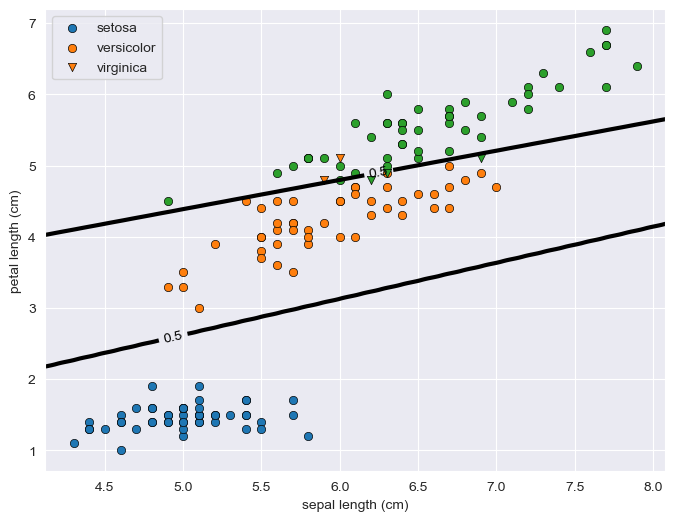

In [64]:
from matplotlib import cm
cmap = cm.get_cmap('tab10')

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
y_pred = lda.predict(X) # lda is model name, use name above for this to work
tp = (y == y_pred)  # true positive

X = np.asarray(X)

# true positives for each class
tp0, tp1, tp2 = tp[y == 0], tp[y == 1], tp[y == 2]
# split features into corresponding classes
X0, X1, X2 = X[y == 0], X[y == 1], X[y == 2]
# split features into true/false positives
# note: ~tp0 means negation of tp0
X0_tp, X0_fp = X0[tp0], X0[~tp0]
X1_tp, X1_fp = X1[tp1], X1[~tp1]
X2_tp, X2_fp = X2[tp2], X2[~tp2]

# class 0 dots
sns.scatterplot(x=X0_tp[:, 0], y=X0_tp[:, 1], color=cmap(0), edgecolor='k')
sns.scatterplot(x=X0_fp[:, 0], y=X0_fp[:, 1], marker='v', color=cmap(0),
                edgecolor='k')

# class 1 dots
sns.scatterplot(x=X1_tp[:, 0], y=X1_tp[:, 1], color=cmap(1), edgecolor='k')
sns.scatterplot(x=X1_fp[:, 0], y=X1_fp[:, 1], marker='v', color=cmap(1),
                edgecolor='k')

# class 2 dot
sns.scatterplot(x=X2_tp[:, 0], y=X2_tp[:, 1], color=cmap(2), edgecolor='k')
sns.scatterplot(x=X2_fp[:, 0], y=X2_fp[:, 1], marker='v', color=cmap(2),
                edgecolor='k')

# decision boundaries
# draw them at the 50% probability level
nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))
# see https://docs.scipy.org/doc/numpy/reference/generated/numpy.c_.html
# ravel returns a contiguous flattened array
Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
cs = ax.contour(xx, yy, Z, [0.5], linewidths=3, colors='black')
ax.clabel(cs, cs.levels, inline=True, fmt='%.1f', fontsize=10)

ax.set_xlabel('sepal length (cm)')
ax.set_ylabel('petal length (cm)')
ax.legend(iris.target_names)
print('Mean accuracy: {:.2f}'.format(lda.score(X, y)))